In [76]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

In [77]:
load_dotenv()

True

In [78]:
model = ChatOpenAI(model_name="gpt-5-mini", temperature=0)

In [79]:
class EvaluationSchema(BaseModel):
    feedback: str = Field(description="Detailed feeback for the essay")
    score: int = Field(description = "Score out of 10", ge=0, le=10)
    

In [80]:
structured_model = model.with_structured_output(EvaluationSchema)

In [81]:
essay = """Artificial intelligence has emerged as one of the most transformative technologies of the 21st century, fundamentally reshaping the landscape of employment across virtually every sector of the global economy. As AI systems become increasingly sophisticated, their influence on the job market has sparked intense debate about the future of work, raising questions about job displacement, skill requirements, and the very nature of human productivity.

The displacement of traditional roles represents perhaps the most visible impact of AI on employment. Automation powered by machine learning and advanced algorithms has already begun replacing routine, repetitive tasks across manufacturing, customer service, data entry, and administrative functions. Self-checkout systems have reduced the need for cashiers, while AI-powered chatbots handle customer inquiries that once required human representatives. In the financial sector, algorithmic trading and automated loan processing have diminished the demand for certain analytical positions. Transportation faces a particularly dramatic shift, with autonomous vehicle technology threatening to disrupt millions of driving jobs in the coming decades.

However, the narrative of AI as purely a job destroyer oversimplifies a more complex reality. History demonstrates that technological revolutions simultaneously destroy and create employment opportunities. The industrial revolution eliminated countless agricultural jobs while spawning entirely new industries and professions. Similarly, AI is generating demand for novel roles that didn't exist a decade ago. Machine learning engineers, AI ethicists, data scientists, prompt engineers, and AI trainers represent just a fraction of the emerging career paths. Moreover, AI is creating indirect employment through the infrastructure, maintenance, and oversight required to support these systems.

The transformation extends beyond simple replacement to fundamental job augmentation. Many roles are evolving as AI tools enhance human capabilities rather than replace them entirely. Doctors now utilize AI diagnostic tools to improve accuracy, lawyers employ AI for document review and legal research, and marketers leverage AI analytics for consumer insights. This augmentation often shifts human workers toward higher-value tasks requiring creativity, emotional intelligence, and complex problem-solving—capabilities that remain distinctly human. Radiologists, for instance, increasingly focus on patient consultation and complex case interpretation while AI handles preliminary image analysis.

The skills demanded by the modern workforce are undergoing rapid evolution in response to AI proliferation. Technical literacy has become essential across professions that previously required minimal technological expertise. Workers must now develop competencies in working alongside AI systems, understanding their capabilities and limitations, and interpreting AI-generated insights. Simultaneously, uniquely human skills—critical thinking, emotional intelligence, creativity, ethical judgment, and interpersonal communication—have gained heightened importance precisely because they're difficult to automate. The premium on adaptability and continuous learning has never been higher, as workers must regularly update their skills to remain relevant.

This transformation has created significant challenges around workforce transition and inequality. Workers in roles most susceptible to automation often lack the resources, time, or access to retrain for emerging opportunities. The displacement tends to disproportionately affect lower-income workers, potentially exacerbating existing economic inequalities. Older workers face particular difficulties adapting to rapidly changing technological landscapes. Geographic disparities emerge as AI-driven opportunities concentrate in technology hubs, leaving other regions economically vulnerable. These dynamics raise urgent questions about social safety nets, educational systems, and policies to ensure inclusive economic growth.

Educational institutions face mounting pressure to prepare students for an AI-integrated future. Traditional curricula emphasizing memorization and routine problem-solving prove increasingly inadequate. Instead, education must foster adaptability, technological fluency, interdisciplinary thinking, and lifelong learning habits. The rise of online learning platforms, ironically often powered by AI, offers new pathways for continuous skill development and career transitions. However, ensuring equitable access to quality education and training remains a persistent challenge.

The gig economy and freelance work have expanded partly due to AI platforms that efficiently match workers with short-term opportunities. While offering flexibility, these arrangements often lack the benefits and security of traditional employment, raising concerns about worker protection and economic stability in an AI-mediated labor market.

Looking forward, the trajectory of AI's impact on employment remains uncertain, depending on technological advancement rates, policy decisions, and societal choices about AI deployment. Optimistic scenarios envision AI liberating humans from mundane tasks, enabling focus on creative and meaningful work, and potentially supporting shorter work weeks or universal basic income. Pessimistic projections warn of massive unemployment, economic disruption, and deepening inequality without proactive intervention.

The challenge facing society is not whether AI will impact jobs—it already has—but how we collectively manage this transformation. Success requires coordinated efforts from governments, businesses, educational institutions, and workers themselves. Policies supporting workforce retraining, portable benefits, and social safety nets become crucial. Businesses must invest in employee development and consider the social implications of automation decisions. Educational systems need fundamental reform to emphasize adaptable, future-ready skills.

In conclusion, AI's impact on current market jobs is profound, multifaceted, and accelerating. While displacement of certain roles is inevitable, the technology also creates opportunities for augmentation, new career paths, and potentially more fulfilling work. The outcome—whether AI serves as a tool for broadly shared prosperity or a driver of increased inequality and economic disruption—depends largely on the choices we make today. Navigating this transition successfully requires acknowledging both AI's tremendous potential and its risks, while proactively building systems that ensure workers can adapt and thrive in an increasingly automated world. The future of work in the age of AI will ultimately be determined not by the technology itself, but by our collective wisdom in shaping its integration into society."""

In [82]:
prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10. Essay: {essay}"

In [83]:
structured_model.invoke(prompt)  

EvaluationSchema(feedback='Overall assessment: The essay is well-written, clear, and professionally presented. It demonstrates strong command of grammar, syntax, and vocabulary, and is logically organized with coherent transitions between paragraphs. The tone is appropriate for an academic/policy audience, and the piece balances nuance—acknowledging both risks and opportunities—with persuasive, measured language.\n\nStrengths:\n- Structure and flow: The essay moves logically from problem statement to impacts, counterarguments, skills and education, socioeconomic implications, and policy recommendations. Paragraphs are focused and transitions are smooth.\n- Clarity and coherence: Sentences are generally clear and ideas are developed coherently. Key concepts (displacement, augmentation, skills, inequality, policy responses) are consistently and effectively articulated.\n- Vocabulary and register: Word choice is precise and suitably formal. Technical terms (e.g., “algorithmic trading,” “p

In [84]:
class UPSCState(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    overall_scores: float

In [85]:
def evaluate_language(state: UPSCState):
    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10. Essay: {state['essay']}"
    output =structured_model.invoke(prompt)
    state['language_feedback'] = output.feedback
    return {"language_feedback": output.feedback, "individual_scores": [output.score]}

In [86]:
def evaluate_analysis(state: UPSCState):
   
    prompt = f"Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10. Essay: {state['essay']}"
    output =structured_model.invoke(prompt)
    state['analysis_feedback'] = output.feedback    
    return {"analysis_feedback": output.feedback, "individual_scores": [output.score]}

In [87]:
def evaluate_clarity_of_thought(state: UPSCState):
   
    f"Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10. Essay: {state['essay']}"
    output =structured_model.invoke(prompt)
    state['clarity_feedback'] = output.feedback
    return {"clarity_feedback": output.feedback, "individual_scores": [output.score]}

In [88]:
def overall_evaluation(state: UPSCState):
    # summary feedback
    prompt = f"Based on the following feedbacks, create a summarized feedback \n Language feedback - {state["language_feedback"]} \n depth of analysis feedback- {state["analysis_feedback"]} \n clarity of thought feedback - {state["clarity_feedback"]}"
    output = model.invoke(prompt)
    state['summary_feedback'] = output.content
    # avg calculation
    state['overall_scores'] = sum(state['individual_scores'])/len(state['individual_scores'])
    return {"overall_feedback": state['summary_feedback'], "overall_scores": state['overall_scores']}

In [89]:
graph = StateGraph(UPSCState)

graph.add_node("evaluate_language", evaluate_language)
graph.add_node("evaluate_analysis", evaluate_analysis)
graph.add_node("evaluate_clarity", evaluate_clarity_of_thought)
graph.add_node("overall_evaluation", overall_evaluation)

graph.add_edge(START, "evaluate_language")
graph.add_edge(START, "evaluate_analysis")
graph.add_edge(START, "evaluate_clarity")
graph.add_edge("evaluate_language", "overall_evaluation")
graph.add_edge("evaluate_analysis", "overall_evaluation")
graph.add_edge("evaluate_clarity", "overall_evaluation")
graph.add_edge("overall_evaluation", END)

workflow = graph.compile()


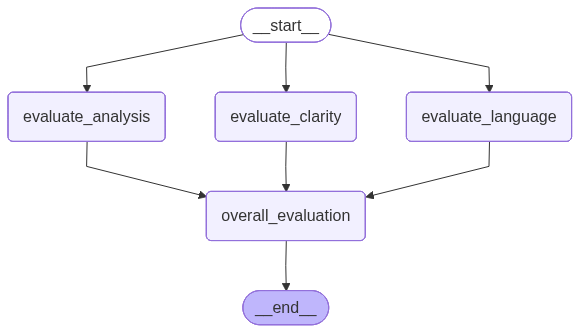

In [90]:
workflow

In [91]:
initial_state = {
    "essay": essay,
}

workflow.invoke(initial_state)

{'essay': "Artificial intelligence has emerged as one of the most transformative technologies of the 21st century, fundamentally reshaping the landscape of employment across virtually every sector of the global economy. As AI systems become increasingly sophisticated, their influence on the job market has sparked intense debate about the future of work, raising questions about job displacement, skill requirements, and the very nature of human productivity.\n\nThe displacement of traditional roles represents perhaps the most visible impact of AI on employment. Automation powered by machine learning and advanced algorithms has already begun replacing routine, repetitive tasks across manufacturing, customer service, data entry, and administrative functions. Self-checkout systems have reduced the need for cashiers, while AI-powered chatbots handle customer inquiries that once required human representatives. In the financial sector, algorithmic trading and automated loan processing have dim